In [11]:
from util.crossvalidation import cross_test_subject, extract_all_mfcc_features
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, roc_auc_score

%matplotlib inline
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [2]:
data = extract_all_mfcc_features()

2/2 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - binary_accuracy: 1.0000


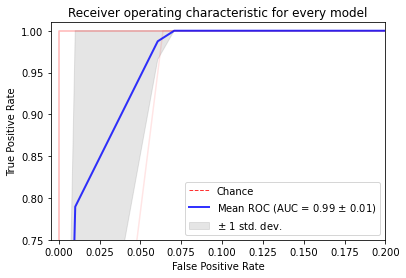

In [24]:
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
fig, ax = plt.subplots()
"""Keras: https://androidkt.com/get-the-roc-curve-and-auc-for-keras-model/"""

def test_clf(target_data, other_data, p):
    label = [1]*len(target_data) + [0]*len(other_data)
    data = target_data + other_data
    data = np.array(data)
    label = np.array(label)
    y_test = [0]
    while not any(y_test):
        X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.35)

    model = Sequential([
    Dense(3600, activation="relu", name="layer1"),
    Dense(512, activation="relu", name="layer3"),
    Dense(64, activation="relu", name="layer4"),
    Dense(32, activation="relu", name="layer5"),
    Dense(1, activation='sigmoid'),
    ])

    model.compile(
    'adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'binary_accuracy'],
    )

    model.fit(
    X_train,
    y_train,
    epochs=100,
    verbose=0
    )

    model.evaluate(X_test, y_test)
    
    y_p = model.predict(X_test)
    y_pred = [1 if y>0.85 else 0 for y in y_p]

    s = sum(y_pred == y_test)/len(y_pred)

    mtx = metrics.confusion_matrix(y_test, y_pred)

    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    
    try:
        tn, fp, fn, tp = mtx.ravel()
        
    except:
        tn, fp, fn, tp = 1, 0, 0, 1
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)

    interp_tpr = np.interp(mean_fpr, fpr_keras, tpr_keras)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    ax.plot(fpr_keras, tpr_keras, color='red', alpha=0.1)
    aucs.append(auc)
    #metrics.plot_roc_curve(sgd_clf, X_test, y_test)
    return s, mtx, sensitivity, specificity

        
        
clf_data = {'score': [], 'sensitivity': [], 'specificity': []}
c_mtx = np.array([[0,  0],[ 0,  0]])
for X in range(1, 3):
    c = []
    sen = []
    spec = []
    target_data, negative_sets = cross_test_subject(data, X, 2, 128)
    for set in negative_sets:
        s, mtx, sensitivity, specificity = test_clf(target_data, set, X)
        c_mtx += mtx
        c.append(s)
        sen.append(sensitivity)
        spec.append(specificity)
    clf_data['score'].append(c)
    clf_data['sensitivity'].append(sen)
    clf_data['specificity'].append(spec)

ax.plot([0, 1], [0, 1], linestyle="--", lw=1, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic for every model",
)
ax.legend(loc="lower right")
plt.savefig("mean_roc_auc_nn.png", dpi=900)
plt.ylim(0.75, 1.01)
plt.xlim(-0.005, 0.2)
plt.savefig("mean_roc_auc_nn_80.png", dpi=900)
plt.show()